# Классификация текста - Анализ эмоциональной окраски

В открытом доступе имеется набор данных отзывов на фильмы IMDB, содержащее 25 000 образцов отрицательных и 25 000 образцов положительных рецензий. Каждый отзыв тщательно промаркирован: 0 - отрицательный отзыв или 1 - положительный отзыв. Построим модель бинарной классификации и обучим ее. В качестве алгоритма обучения будем использовать логистическую регрессию.

## Загрузка и подготовка данных


In [1]:
import pandas as pd
 
df = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1')
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Проверим пропущенные значения

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Узнаем, сколько существует экземпляров каждого класса (0- отрицательный, 1 - положительный):

In [3]:
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  When i got this movie free from my job, along ...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

Количество положительных и отрицательных образцов равны, но в количество уникальных образцов меньше, чем количество образцов для данного класса. Это означает, что в наборе данных есть дублирующиеся строки, и именно они могут исказить модель машинного обучения. 
Удалим эти строки и повторно проверим:

In [4]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Once again Mr. Costner has dragged out a movie...   
1          24884  24884  I went and saw this movie last night after bei...   

                
          freq  
Sentiment       
0            1  
1            1

Далее с помощью класса [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) подготовим и выполним векторизацию в столбце Text. Установим `min_df` равным 20, чтобы игнорировать слова, которые редко встречаются в обучающем тексте. Это уменьшает вероятность возникновения ошибок нехватки памяти и, возможно, делает модель более точной. Также используем параметр `ngram_range`, чтобы позволить CountVectorizer включать пары слов, а также отдельные слова:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=20)
x = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

Помимо создания векторизованного текста, `Countvectorizer` преобразует текст в строчные буквы, удаляет стоп-слова и знаки препинания и т.д. Давайте посмотрим, как он очищает текст перед его векторизацией, преобразуя строку, а затем меняя преобразование на противоположное.

In [6]:
text = vectorizer.transform(['The long l3ines   and; pOOr customer# service really turned me off...123.'])
text = vectorizer.inverse_transform(text)
print(text)

[array(['customer', 'long', 'poor', 'really', 'service', 'turned'],
      dtype='<U25')]


Теперь разделим набор данных на обучающий и тестовый. Мы будем использовать разделение 50/50, поскольку всего имеется почти 50 000 образцов:

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)  

## Обучение модели

Воспользуемся классом [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) который использует логистическую регрессию [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) для обучения модели:

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

Проверьте обученную модель и отобразите результаты в виде матрицы ошибок:

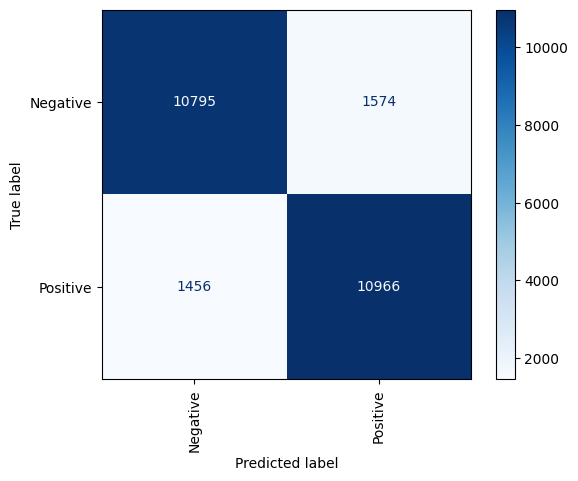

In [9]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, x_test, y_test,
                   display_labels=['Negative', 'Positive'],
                   cmap='Blues', xticks_rotation='vertical')

Матрица ошибок показывает, что модель правильно идентифицировала 10 795 отрицательных отзывов, но при этом ошибочно классифицировала 1574 отзыва. Модель правильно определила 10 966 положительных отзывов и ошиблась 1456 раз

## Использование обученной модели для анализа текста

Давайте оценим review, предварительно векторизовав текст и передадим его в метод `predict_proba`. Совпадают ли результаты с тем, что мы ожидаем?

In [10]:
review = 'The long lines and poor customer service really turned me off.'
model.predict_proba(vectorizer.transform([review]))[0][1]

0.09182926992019849

Модель предсказывает, что данный отзыв отрицательный.

Теперь берем позитивный отзыв и посмотрим, согласна ли модель с тем, что отзыв положительное.

In [11]:
review = 'The food was great and the service was excellent!'
model.predict_proba(vectorizer.transform([review]))[0][1]

0.8536125428544099

Попробуйте проверить Ваши предложения. Согласны ли вы с прогнозом модели. 

Данный модель не идеальна, но пропустив через нее сотни отзывов или комментариев можно получить достоверное представление о позитивности или негативности текста

Иногда встроенный в CountVectorizer список стоп-слов снижает точность модели. Попробуйте удалить stop_words = 'english' и запустите код снова. Проверьте мартицу ошибок. Увеличилась или уменьшилась точность? Попробуйте изменить и другие параметры: min_df, ngram_range. Datascientistы часто пробуют множество различных комбинаций параметров, чтобы определить, какая из них дает наилучшие результаты.